## Load Data and Prepare Features
Load train and validation splits, extract features and targets, and handle missing values using median.


In [5]:
# Prepare features and targets for training
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

df_train = pd.read_csv('data/splits/train.csv')
df_val = pd.read_csv('data/splits/val.csv')

# Prepare features (X): day_of_month, is_weekend, is_public_holiday, days_from_summer_start
feature_cols = ['day_of_month', 'is_weekend', 'is_public_holiday', 'days_from_summer_start']
X_train = df_train[feature_cols].values
X_val = df_val[feature_cols].values

# Prepare targets (y): all 60 days-to-departure columns
target_cols = [col for col in df_train.columns if 'days to departure' in col]
y_train = df_train[target_cols].values
y_val = df_val[target_cols].values

# Handle missing values in targets (fill with median of each column)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
y_train = imputer.fit_transform(y_train)
y_val = imputer.transform(y_val)

print(f"Training features shape: {X_train.shape}")
print(f"Training targets shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Validation targets shape: {y_val.shape}")

Training features shape: (64, 4)
Training targets shape: (64, 60)
Validation features shape: (14, 4)
Validation targets shape: (14, 60)


## Train Model
Train a XGBoost regression model to predict flight prices for all 60 days-to-departure horizons.


In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
# Train multi-output regression model using XGBoost
# Use MultiOutputRegressor to handle multiple target outputs
base_model = XGBRegressor(
    max_depth=100,
    learning_rate=0.001,
    n_estimators=600,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

model = MultiOutputRegressor(base_model)
print("Training model...")
model.fit(X_train, y_train)
print("Training completed!")

y_val_pred = model.predict(X_val)
print("Predictions completed!")


Training model...
Training completed!


## Evaluate and Visualize Results
Calculate MAE metrics and create visualizations comparing predictions to ground truth across different days-to-departures.



PREDICTION COMPARISON SUMMARY

Validation Results:
Overall MAE: 65.89

Total predictions: 840
Number of samples: 14
Number of outputs per sample: 60

Comparison DataFrame (first 20 rows):
    sample_idx  days_to_departure      actual   predicted  absolute_error
0            0                  1  435.381250  548.306458      112.925208
1            0                  2  482.261290  535.154358       52.893068
2            0                  3  529.019355  541.528381       12.509027
3            0                  4  355.332143  544.478394      189.146251
4            0                  5  391.777419  556.498840      164.721421
..         ...                ...         ...         ...             ...
95           1                 36  516.318400  532.308655       15.990255
96           1                 37  581.525000  526.234314       55.290686
97           1                 38  529.680417  519.336975       10.343442
98           1                 39  517.160400  511.468170        5.6922

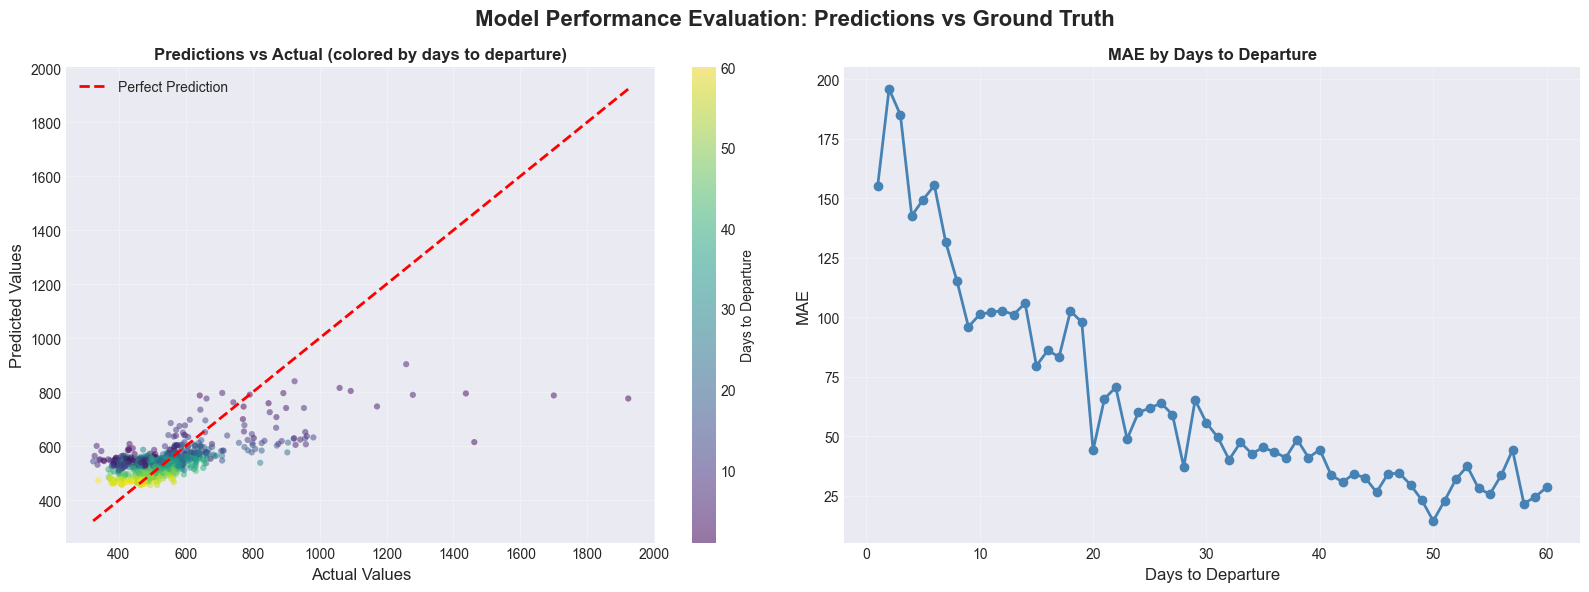

In [19]:
# ============================================================================
# Model Evaluation Visualizations
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid')
    except OSError:
        plt.style.use('ggplot')
sns.set_palette("husl")

# Flatten predictions and actuals for comparison DataFrame
n_samples, n_outputs = y_val.shape
comparison_data = []

for sample_idx in range(n_samples):
    for output_idx in range(n_outputs):
        actual = y_val[sample_idx, output_idx]
        predicted = y_val_pred[sample_idx, output_idx]
        abs_error = abs(actual - predicted)
        pct_error = (abs_error / actual * 100) if actual != 0 else np.nan
        
        # Extract days to departure from column name
        days_to_departure = int(target_cols[output_idx].split()[0])
        
        comparison_data.append({
            'sample_idx': sample_idx,
            'days_to_departure': days_to_departure,
            'actual': actual,
            'predicted': predicted,
            'absolute_error': abs_error,
        })

comparison_df = pd.DataFrame(comparison_data)

# Display comparison DataFrame summary
print("\n" + "="*80)
print("PREDICTION COMPARISON SUMMARY")
print("="*80)

mae_per_output = [mean_absolute_error(y_val[:, i], y_val_pred[:, i]) for i in range(y_val.shape[1])]
overall_mae = mean_absolute_error(y_val, y_val_pred)

print(f"\nValidation Results:")
print(f"Overall MAE: {overall_mae:.2f}")

print(f"\nTotal predictions: {len(comparison_df)}")
print(f"Number of samples: {n_samples}")
print(f"Number of outputs per sample: {n_outputs}")
print(f"\nComparison DataFrame (first 20 rows):")
print(comparison_df.head(100))

# ============================================================================
# Visualizations: Predictions vs Actual and MAE by Days to Departure
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Model Performance Evaluation: Predictions vs Ground Truth', fontsize=16, fontweight='bold')

# Plot 1: Scatter plot - Predictions vs Actual
ax1 = axes[0]
scatter = ax1.scatter(comparison_df['actual'], comparison_df['predicted'], 
                     alpha=0.5, s=20, c=comparison_df['days_to_departure'], 
                     cmap='viridis', edgecolors='none')
min_val = min(comparison_df['actual'].min(), comparison_df['predicted'].min())
max_val = max(comparison_df['actual'].max(), comparison_df['predicted'].max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Values', fontsize=12)
ax1.set_ylabel('Predicted Values', fontsize=12)
ax1.set_title('Predictions vs Actual (colored by days to departure)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Days to Departure')

# Plot 2: MAE by Days to Departure
ax2 = axes[1]
days_list = [int(col.split()[0]) for col in target_cols]
ax2.plot(days_list, mae_per_output, marker='o', linewidth=2, markersize=6, color='steelblue')
ax2.set_xlabel('Days to Departure', fontsize=12)
ax2.set_ylabel('MAE', fontsize=12)
ax2.set_title('MAE by Days to Departure', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(0, 61, 10))

plt.tight_layout()
plt.show()